# Изучение VIN-кодов автомобилей при помощи регулярных выражений re
Задача этого проекта - обработать сырые данные при помощи регулярных выражений в Python и предсказать цену машины марки Форд по VIN номеру.
Вы познакомитесь с модулем re в Python
Узнаете основные конструкции регулярных выражений
Получите навык решений задач с помощью регулярных выражений


## Загрузка и анализ данных

### Импорт библиотек

In [1]:
#!pip install --upgrade lightgbm
#!pip install --upgrade pandas



In [166]:
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import re
from sklearn.dummy import DummyClassifier
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from math import sqrt
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import warnings

### Константы

In [141]:
RANDOM_STATE = RS = 654321
TEST_SIZE = .25
# выделение в тексте
BOLD = "\033[1m"
ITALIC = "\033[3m"
END = "\033[0m"
CR = '\n'

### Вспомогательные функции

In [4]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print (BOLD + 'Изучим исходные данные' + END)
    print(data.info())
    print(BOLD + CR + f'Вывод первых {size} строк датафрейма:' + END)
    display(data.head(size))
    print(BOLD + CR + 'Вывод основной информации о датафрейме:' + END)
    print(CR + 'Количество строк: ', data.shape[0])
    print('Количество столбцов: ', data.shape[1])
    categ_col = data.columns[data.dtypes == 'object']
    num_col = data.columns[data.dtypes != 'object']
    print('Количество категориальных признаков: ', len(categ_col))
    print('Количество числовых признаков: ', len(num_col))
    missed_cells = data.isna().sum().sum()/(data.shape[0]*(data.shape[1]-1))
    missed_rows = sum(data.isna().sum(axis = 1)>0)/data.shape[0]
    print (BOLD + CR + 'Проверка пропусков'+ END)
    print ('Количество пропусков: {:.0f}'.format(data.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ END)
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))
    print(BOLD +  CR + 'Описание количественных данных:'+ END)
    display(pd.concat([pd.DataFrame(np.array([data[num_col].isna().sum(), data[num_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[num_col].columns), data.describe().T], axis=1))
    print(BOLD + CR + 'Описание категориальных данных:'+ '\033[0m')
    display(pd.concat([pd.DataFrame(np.array([data[categ_col].isna().sum(), data[categ_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[categ_col].columns), data.describe(include='object').T], axis=1))
    ## Проверим дубликаты
    print (BOLD +  CR + 'Проверка на дубликаты'+ END)
    print('Количество полных дубликатов: ', data.duplicated().sum())
        

### Оформление

In [5]:
# оформление Pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

# Matplotlib, Seaborn
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150 # dpi для рендеринга графиков
# оформление — скрытие предупреждений
#warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore")

### Чтение данных

Наши данные выгружены в текстовом виде. Предварительный просмотр в текстовом редакторе показал, что файл содержит текстовые сюрпризы. От заказчика есть информация, что общее количество валидных данных - 71884. Нужно распарсить данные при помощи re

In [6]:
with open('D:/_DS/Mast_4_re/vin_ford_train.txt', 'r', encoding='utf-8')as f:
    vin_text = f.read()

In [7]:
vin_text[:500]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK4KC6EBA72011:25100]правил [1FTFX1EF2EKE24350:26700][1ZVBP8EM0D5237253:11600][1FDNE1BW5BDA64735:13200'

И мы видим настоящие вин-коды в сочетании с невесть откуда прокравшимся дядей верных правил

## Формат VIN- кода

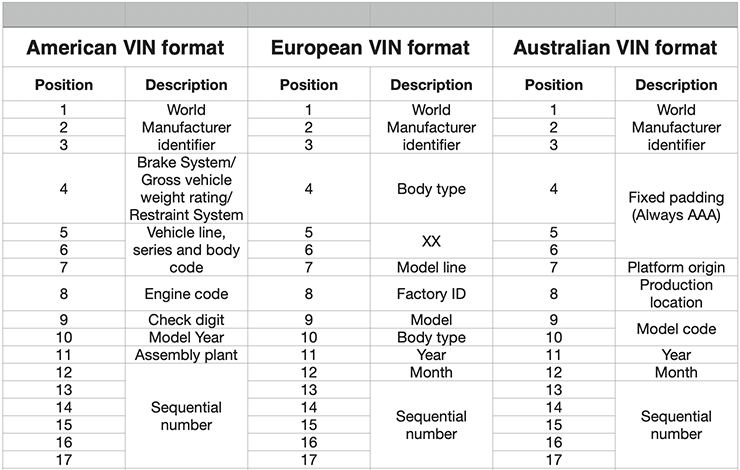

Номер состоит из букв и из цифр. Символами VIN могут быть заглавные буквы от A до Z и цифры от 1 до 0; однако буквы I, O и Q никогда не используются во избежание ошибок при чтении. В VIN не допускается использование знаков или пробелов. Не бывает двух одинаковых ВИН.

Добавим разрешённые символы:

In [8]:
allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

Мы будем использовать для разбора на составные части только Северо-Американский формат VIN, так как у нас только Форд

In [117]:
wmi = f'(?P<wmi>[{allowed}]{{3}})'#1-3
brake = f'(?P<brake>[{allowed}])'#4
model = f'(?P<model>[{allowed}]{{3}})'#5-7
engine = f'(?P<engine>[{allowed}])'#8
check = f'(?P<check>[{allowed}])'#9
year = f'(?P<year>[{allowed}])'#10
plant = f'(?P<plant>[{allowed}])'#11
num = f'(?P<num>[{allowed}]{{3}}\\d{{3}})'#12-17
price = f'(?P<price>\\d+)'#18-
wmi

'(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})'

In [118]:
vin = f'\\[{wmi}{brake}{model}{engine}{check}{year}{plant}{num}:{price}\\]'


In [119]:
vin_re = re.compile(vin)
vin_re


re.compile(r'\[(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<brake>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<year>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<num>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3}\d{3}):(?P<price>\d+)\]',
re.UNICODE)

In [120]:
data = pd.DataFrame([x.groupdict() for x in vin_re.finditer(vin_text)]) 

In [121]:
data.head(5)

,wmi,brake,model,engine,check,year,plant,num,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   num     71884 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


Цена у нас цифровая, остальное - строки

In [123]:
data['price'] = data['price'].astype(int)

In [124]:
about_df(data)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   num     71884 non-null  object
 8   price   71884 non-null  int32 
dtypes: int32(1), object(8)
memory usage: 4.7+ MB
None

Вывод первых 5 строк датафрейма:


,wmi,brake,model,engine,check,year,plant,num,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600



Вывод основной информации о датафрейме:

Количество строк:  71884
Количество столбцов:  9
Количество категориальных признаков:  8
Количество числовых признаков:  1

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Описание количественных данных:


,кол-во пропусков,"доля пропусков, %",count,mean,std,min,25%,50%,75%,max
price,0.00,0.00,71884.00,14321.45,7827.06,1000.00,8800.00,13500.00,19500.00,36500.00



Описание категориальных данных:


,кол-во пропусков,"доля пропусков, %",count,unique,top,freq
wmi,0.00,0.00,71884,14,1FM,18347
brake,0.00,0.00,71884,26,D,12370
model,0.00,0.00,71884,365,P0H,6171
engine,0.00,0.00,71884,32,2,7015
check,0.00,0.00,71884,11,1,6622
year,0.00,0.00,71884,25,D,17286
plant,0.00,0.00,71884,21,R,10535
num,0.00,0.00,71884,68215,B55197,4



Проверка на дубликаты
Количество полных дубликатов:  0


Проверка на дубликаты показала, что количество полных дубликатов датасета - 0

In [20]:
data = data.drop_duplicates()
data = data.reset_index(drop = True)

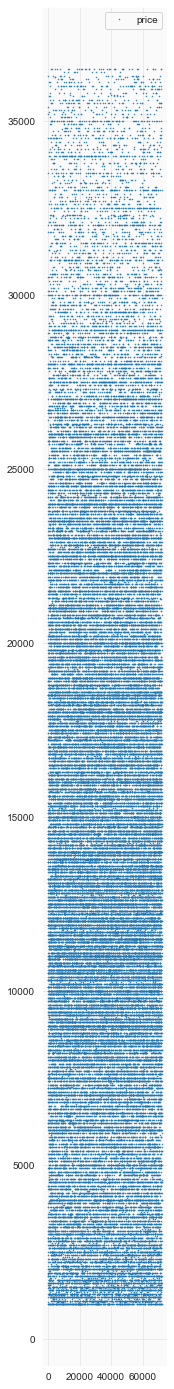

In [126]:
data.plot(
    lw=0, marker=".", subplots=True, layout=(-1, 5), figsize=(13, 25), markersize=1
);

In [205]:
data['price'].describe()

count   71884.00
mean    14321.45
std      7827.06
min      1000.00
25%      8800.00
50%     13500.00
75%     19500.00
max     36500.00
Name: price, dtype: float64

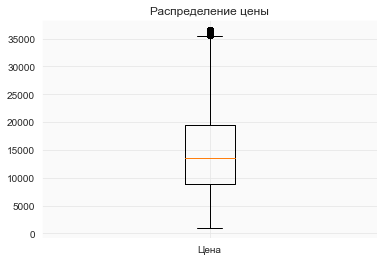

In [203]:
plt.boxplot(data['price'], labels=['Цена'])
plt.title('Распределение цены')
plt.show()

На гистограмме распределения мы видим, что цена автомобилей варьируется от 1000 до 36500, но свыше 35000 уже значения редкие как выбросы. Среднее значение около 14 000.

In [127]:
data.columns

Index(['wmi', 'brake', 'model', 'engine', 'check', 'year', 'plant', 'num',
       'price'],
      dtype='object')

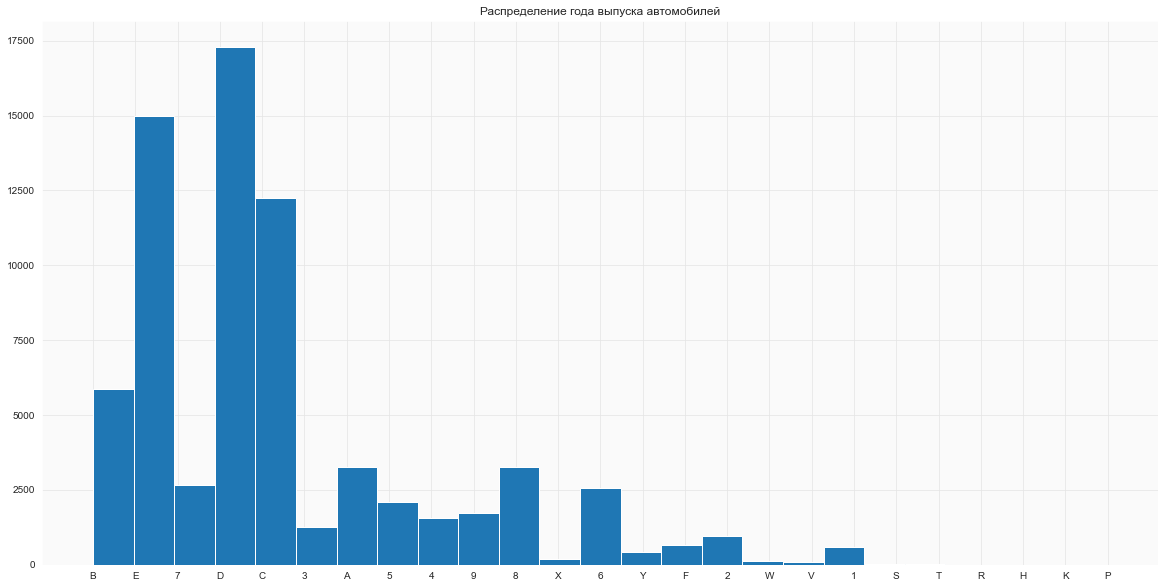

In [131]:
data['year'].hist( figsize = (20,10), bins = 25,)
plt.title('Распределение года выпуска автомобилей')
plt.show()

Самая Большая категория - D, за ней идёт E, третье место у C. Остальные - с сильным отрывом.

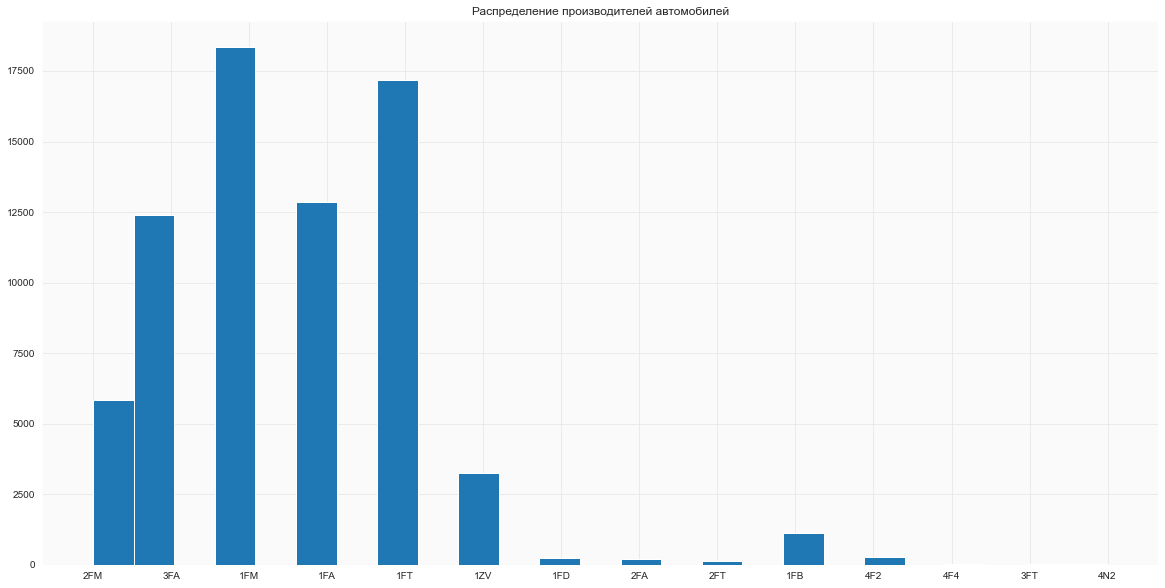

In [194]:
data['wmi'].hist( figsize = (20,10), bins = 25,)
plt.title('Распределение производителей автомобилей')
plt.show()

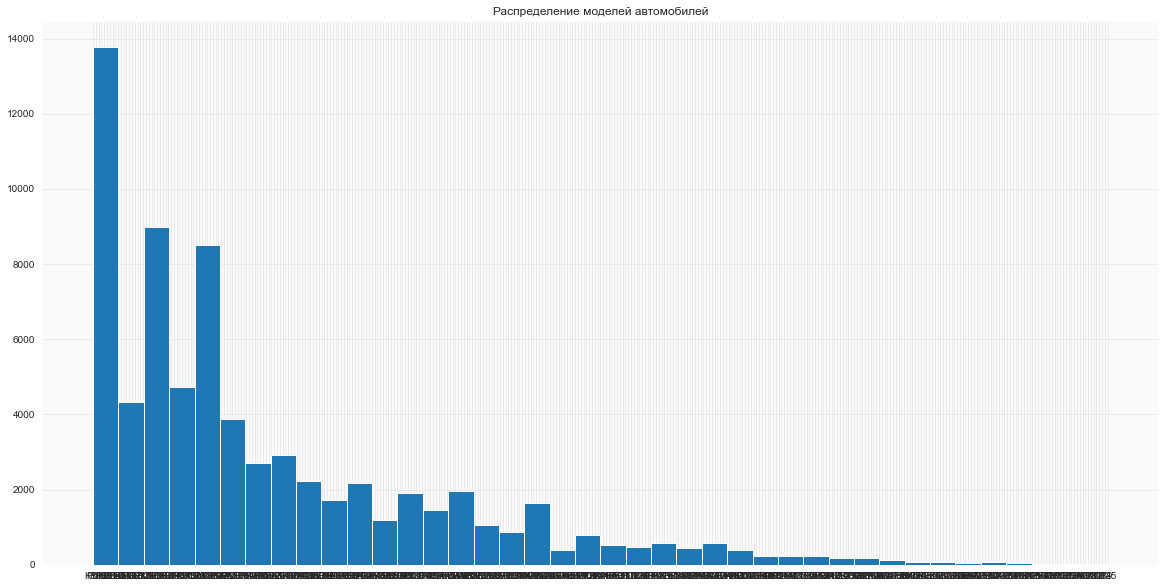

In [196]:
data['model'].hist( figsize = (20,10), bins = 40,)
plt.title('Распределение моделей автомобилей')
plt.show()

## Подготовка признаков

In [133]:
y =target = data['price']

In [134]:
X = data.drop('price', axis = 1)

In [149]:
cat_features = list(X.columns)

In [204]:
train_x, test_x, train_y, test_y = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, random_state=RS,
                                                    
                                                   )

## Дамми модель

Проверим разные стратегии для дамми-модели

In [170]:
strat = ["most_frequent", "stratified", "uniform", "uniform"]
for s in strat:
    dummy_clf = DummyClassifier(strategy=s,random_state=RS)
    dummy_clf.fit(train_x,train_y)
    print(s)
    dummy_pred = dummy_clf.predict(test_x)
    rmse_dummy = root_mean_squared_error(test_y, dummy_pred)
    mae_dummy = mean_absolute_error(test_y, dummy_pred)
    print("Root Mean Squared Error на тестовой выборке:", rmse_dummy)
    print("Mean Absolute Error на тестовой выборке:", mae_dummy)

most_frequent
Root Mean Squared Error на тестовой выборке: 8541.258097974893
Mean Absolute Error на тестовой выборке: 6693.4962439485835
stratified
Root Mean Squared Error на тестовой выборке: 11054.243981053378
Mean Absolute Error на тестовой выборке: 8850.311167992877
uniform
Root Mean Squared Error на тестовой выборке: 12786.00213953972
Mean Absolute Error на тестовой выборке: 10363.495131044461
uniform
Root Mean Squared Error на тестовой выборке: 12786.00213953972
Mean Absolute Error на тестовой выборке: 10363.495131044461


Лучший вариант даёт stratified, его и возьмём для сравнения

## Подбор гиперпараметров моделей

### модель CatBoost

In [175]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 200, 2400),
        "depth": trial.suggest_int("depth", 2, 6),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 5),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.08, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"])#, "MVS"])
    }
    train_pool = Pool(train_x,
                  label=train_y,
                  cat_features=cat_features
                      )
    test_pool = Pool(test_x,
                  label=test_y,
                  cat_features=cat_features
                  )
    model_cbc = CatBoostRegressor(**param, 
                                   loss_function = 'RMSE',
                                   eval_metric = 'MAE',
                                   thread_count=-1, 
                                   random_seed=RANDOM_STATE, 
                                   verbose=0, 
                                   cat_features=cat_features)
    predict_cbc = cross_val_predict(model_cbc, train_x, train_y, cv=5)
    score_cbc = mean_absolute_error(train_y, predict_cbc)
    return score_cbc
sampler = optuna.samplers.RandomSampler(seed=RANDOM_STATE)
study_cbc = optuna.create_study(sampler=sampler, direction='maximize')
study_cbc.optimize(objective, n_trials=10)
print('Best hyperparameters Catboost:', study_cbc.best_params)
print('Best MAE Catboost:', study_cbc.best_value)


[I 2024-04-22 20:26:37,236] A new study created in memory with name: no-name-43072548-ae6d-43d2-9bab-3ec595891a95
[I 2024-04-22 20:27:29,341] Trial 0 finished with value: 2158.5124290360372 and parameters: {'iterations': 710, 'depth': 5, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.09386343260830302, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 2158.5124290360372.
[I 2024-04-22 20:27:46,299] Trial 1 finished with value: 2419.0197837822134 and parameters: {'iterations': 271, 'depth': 6, 'l2_leaf_reg': 4, 'colsample_bylevel': 0.08133202217118066, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 2419.0197837822134.
[I 2024-04-22 20:28:25,464] Trial 2 finished with value: 2233.0115086599326 and parameters: {'iterations': 663, 'depth': 4, 'l2_leaf_reg': 3, 'colsample_bylevel': 0.09017187472495534, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 2419.0197837822134.
[I 2024-04-22 

Best hyperparameters Catboost: {'iterations': 534, 'depth': 2, 'l2_leaf_reg': 2, 'colsample_bylevel': 0.08132303744482623, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}
Best ROC-AUC Catboost: 2528.0843121363177


In [178]:
model_cb = CatBoostRegressor(iterations=534,
                                depth=5,
                                #learning_rate=0.001,
                                l2_leaf_reg=2,
                                loss_function='RMSE',
                                random_seed=RS
)


model_cb.fit(train_x, train_y, cat_features= cat_features, plot= True)
y_pred = model_cb.predict(test_x)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7645.4692561	total: 73.9ms	remaining: 39.4s
1:	learn: 7476.4785769	total: 146ms	remaining: 38.9s
2:	learn: 7318.1268513	total: 192ms	remaining: 34s
3:	learn: 7162.5886917	total: 232ms	remaining: 30.7s
4:	learn: 7010.4535276	total: 296ms	remaining: 31.3s
5:	learn: 6863.5819337	total: 354ms	remaining: 31.1s
6:	learn: 6721.4592138	total: 389ms	remaining: 29.3s
7:	learn: 6588.5306903	total: 429ms	remaining: 28.2s
8:	learn: 6457.8815755	total: 474ms	remaining: 27.6s
9:	learn: 6331.0726279	total: 526ms	remaining: 27.6s
10:	learn: 6208.2534703	total: 569ms	remaining: 27s
11:	learn: 6089.4360810	total: 614ms	remaining: 26.7s
12:	learn: 5977.4513310	total: 659ms	remaining: 26.4s
13:	learn: 5870.1691291	total: 708ms	remaining: 26.3s
14:	learn: 5766.1678237	total: 745ms	remaining: 25.8s
15:	learn: 5665.8765402	total: 785ms	remaining: 25.4s
16:	learn: 5570.1057587	total: 831ms	remaining: 25.3s
17:	learn: 5477.1999416	total: 873ms	remaining: 25s
18:	learn: 5386.7285352	total: 920ms	remain

In [179]:
mse = mean_squared_error(test_y, y_pred)

rmse = root_mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)

Root Mean Squared Error на тестовой выборке: 2857.8018828430663
Mean Absolute Error на тестовой выборке: 2026.3235627540569


Вычислим вычисляет коэффициент детерминации R^2. Это статистическая мера, которая показывает, как хорошо предсказания приближаются к фактическим значениям. Более высокие значения R^2 указывают на лучшее качество модели.

In [180]:
r2 = r2_score(test_y, y_pred)
print("R2 на тестовой выборке:", r2)

R2 на тестовой выборке: 0.8672610197692596


In [191]:
cat_imp = pd.Series(model_cb.feature_importances_, X.columns)

In [192]:
cat_imp_max = cat_imp[cat_imp> 0.001].round(3)
cat_imp_max = pd.DataFrame(cat_imp_max)
cat_imp_max = cat_imp_max.sort_values(by = 0,ascending = False)
cat_imp_max

,0
year,33.67
model,29.61
brake,14.78
engine,10.69
plant,6.24
wmi,4.54
check,0.47


Text(0.5, 1.0, 'Важность признаков Catboost ')

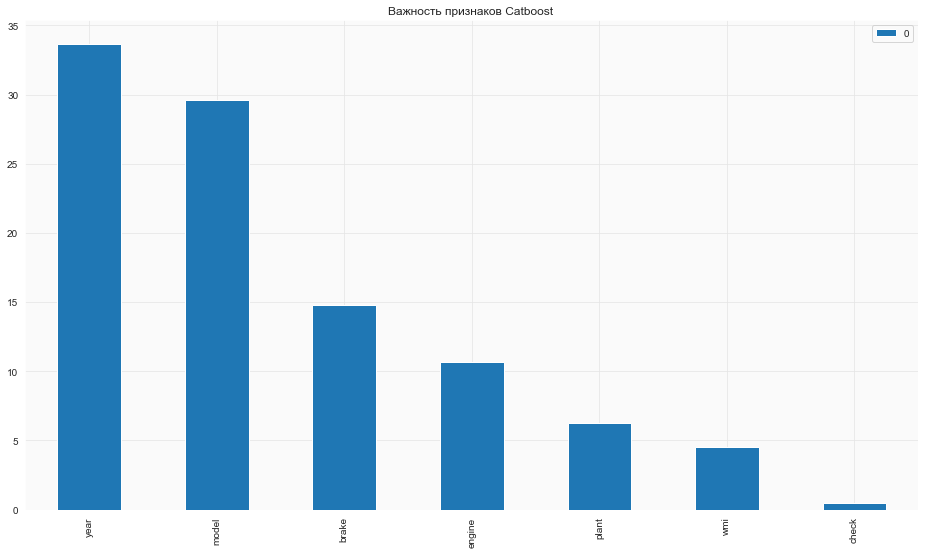

In [189]:
cat_imp_max.plot.bar(figsize=(16,9)).set_title("Важность признаков Catboost ")

Посмотрим на распределение наших значений предсказанных цен:

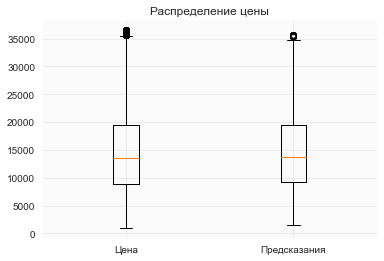

In [206]:
plt.boxplot([data['price'], y_pred], labels=['Цена', 'Предсказания'])
plt.title('Распределение реальной и предсказанной цены')
plt.show()

Среднее реальных цен и предсказаний весьма близко, как и дисперсия, 

## Вывод
Мы провели предобработку данных, произвели извлечение из VIN-кода следующих параметров:
- года выпуска автомобиля,
- модели,
- тип тормозов
- типа двигателя,
- завод
- производитель
- проверочное число
Подобрали параметры модели CatBoostRegressor для определения стоимости автомобиля. 
Лучшие гиперпараметры Catboost: {'iterations': 534, 'depth': 2, 'l2_leaf_reg': 2, 'colsample_bylevel': 0.08132303744482623, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}
Best ROC-AUC Catboost: 2528.0843121363177
Получены предсказания на валидационных данных, 
Root Mean Squared Error на тестовой выборке: 2857.80
Mean Absolute Error на тестовой выборке: 2026.32
R2 на тестовой выборке: 0.87
Важность признаков для модели CatBoostRegressor:
year	33.67
model	29.61
brake	14.78
engine	10.69
plant	6.24
wmi	    4.54
check	0.47
И даже немного важно проверочное число.
Получилась вполне сбалансированная модель, которую теперь можно обучить на полном датасете и создать приложение для загрузки VIN-кода и определения стоимости автомобиля.